

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : 'Data/Historical_Gold_data_April.csv',
           'SILVER': 'Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': 'Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'Live_Sentiments.csv'
Live_Sentiments_file_dir = 'Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = 'Sentiments'

best_models_dir = {'GOLD': 'Models/GOLD_MODELS', 'SILVER' : 'Models/SILVER_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS', 'SILVER' : 'Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : 'Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)

Enter the Commodity Name SILVER


## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [4]:
# Function to download historical price data
def download_price_data(ticker, start='2003-01-01', end='2025-04-05'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [5]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : Data/Historical_Silver_data_April.csv
Ticker code for SILVER : SI=F


### Fetch Realtime Data

In [6]:
# Function to fetch real-time data
def fetch_real_time_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    data.columns.name = None
    data.index = pd.to_datetime(data.index).date
    # Select and standardize the required columns
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

### Merge Historical Data with Realtime Data

In [7]:
real_time_data = fetch_real_time_data(ticker, period='10d', interval='1h')
# Convert index to Date column
real_time_data['Date'] = real_time_data.index
# Reset index
real_time_data.reset_index(drop=True, inplace=True)
# Ensure 'Date' is datetime without timezone
real_time_data['Date'] = pd.to_datetime(real_time_data['Date']).dt.normalize()
# Reorder columns
real_time_data = real_time_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print output
print(real_time_data.head())
# ######## Combine Real TIme data with Historical data
commodity_data = real_time_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close  Volume
0 2025-04-04  31.590000  31.719999  31.535000  31.565001       0
1 2025-04-04  31.565001  31.799999  31.549999  31.730000    1247
2 2025-04-04  31.730000  31.790001  31.495001  31.549999    1877
3 2025-04-04  31.545000  31.570000  31.190001  31.275000    5238
4 2025-04-04  31.275000  31.480000  31.195000  31.434999    4435


In [8]:
commodity_data


,Date,Open,High,Low,Close,Volume
0,2025-04-04,31.590000,31.719999,31.535000,31.565001,0
1,2025-04-04,31.565001,31.799999,31.549999,31.730000,1247
2,2025-04-04,31.730000,31.790001,31.495001,31.549999,1877
3,2025-04-04,31.545000,31.570000,31.190001,31.275000,5238
4,2025-04-04,31.275000,31.480000,31.195000,31.434999,4435
...,...,...,...,...,...,...
162,2025-04-15,32.345001,32.365002,32.220001,32.255001,999
163,2025-04-15,32.259998,32.305000,32.174999,32.290001,1064
164,2025-04-15,32.290001,32.424999,32.290001,32.380001,1987
165,2025-04-15,32.384998,32.404999,32.294998,32.320000,1168


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [9]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2024'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [10]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2023-01-01,27720709000000
1,2023-01-02,27720709000000
2,2023-01-03,27720709000000
3,2023-01-04,27720709000000
4,2023-01-05,27720709000000
...,...,...
646,2003-01-27,11456450000000
647,2003-01-28,11456450000000
648,2003-01-29,11456450000000
649,2003-01-30,11456450000000


####  Interest rate data

In [11]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14296\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25807,2025-02-25,4.33
25808,2025-02-26,4.33
25809,2025-02-27,4.33
25810,2025-02-28,4.33


####  GDP to Debt data

In [12]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


####  Inflation data

In [13]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
844,2024-11-01,4.64
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33


####  ETF data

In [14]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [15]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta
#reading live sentiments
# API KEY: https://newsapi.org/register/success

# Function to fetch news from NewsAPI (replace with your API key)
API_KEY = "ca5eb0d931a345609fc85ed9affd48d5"
NEWS_API_URL = "https://newsapi.org/v2/everything"

def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Function to analyze sentiment using FinBERT
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")
#sentiment_pipeline = pipeline('sentiment-analysis',  model="google-bert/bert-base-uncased")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Fetch and analyze news sentiment
def get_gold_sentiment():
    news_data = fetch_news(commodity)
    
    if not news_data:
        return pd.DataFrame()
    
    df = pd.DataFrame(news_data, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df



#### Apply Sentiment analysis on Live data and save them in disk

In [16]:
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)

# Save the new data
sentiment_df = get_gold_sentiment()
sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-03-23T14:30:36Z  Hazelight’s Split Fiction Could Go From Game t...   
1  2025-03-20T12:35:12Z  Netanyahu Gives John Fetterman Silver-Plated P...   
2  2025-03-27T15:22:59Z  Pokémon Legends: Z-A’s gameplay will change de...   
3  2025-04-13T22:48:11Z                    People are turning on Elon Musk   
4  2025-04-03T23:34:34Z  New Footage From The Fantastic Four: First Ste...   

  Sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4   neutral  
                   Date                                           Headline  \
0  2025-03-23T14:30:36Z  Hazelight’s Split Fiction Could Go From Game t...   
1  2025-03-20T12:35:12Z  Netanyahu Gives John Fetterman Silver-Plated P...   
2  2025-03-27T15:22:59Z  Pokémon Legends: Z-A’s gameplay will change de...   
3  2025-04-13T22:48:11Z                    People are turning on Elon Musk   
4  2025-04-03T23:34:34Z  New Footage From The Fantastic F

,Date,Headline,Sentiment,Sentiment_score
0,2025-03-23,Hazelight’s Split Fiction Could Go From Game t...,neutral,0
1,2025-03-20,Netanyahu Gives John Fetterman Silver-Plated P...,neutral,0
2,2025-03-27,Pokémon Legends: Z-A’s gameplay will change de...,neutral,0
3,2025-04-13,People are turning on Elon Musk,neutral,0
4,2025-04-03,New Footage From The Fantastic Four: First Ste...,neutral,0


#### Load Historical Sentiment data

In [17]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [18]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [19]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [20]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [21]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            167 non-null    object 
 1   Open            167 non-null    float64
 2   High            167 non-null    float64
 3   Low             167 non-null    float64
 4   Close           167 non-null    float64
 5   Volume          167 non-null    int64  
 6   GDP             0 non-null      float64
 7   Interest_rates  0 non-null      float64
 8   Inflation_rate  0 non-null      float64
 9   DebtToGDP       0 non-null      float64
 10  ETF_Value       0 non-null      float64
dtypes: float64(9), int64(1), object(1)
memory usage: 14.5+ KB
Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
GDP               167
Interest_rates    167
Inflation_rate    167
DebtToGDP         167
ETF_Value         167
dtype

### 2.4 Processing NULL values from merged data

In [22]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14296\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14296\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\

### Outlier Treatment

In [23]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value


In [24]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0
1,2025-04-04,31.565001,31.799999,31.549999,31.730000,1247,0.0,0.0,0.0,0.0,0.0
2,2025-04-04,31.730000,31.790001,31.495001,31.549999,1877,0.0,0.0,0.0,0.0,0.0
3,2025-04-04,31.545000,31.570000,31.190001,31.275000,5238,0.0,0.0,0.0,0.0,0.0
4,2025-04-04,31.275000,31.480000,31.195000,31.434999,4435,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
162,2025-04-15,32.345001,32.365002,32.220001,32.255001,999,0.0,0.0,0.0,0.0,0.0
163,2025-04-15,32.259998,32.305000,32.174999,32.290001,1064,0.0,0.0,0.0,0.0,0.0
164,2025-04-15,32.290001,32.424999,32.290001,32.380001,1987,0.0,0.0,0.0,0.0,0.0
165,2025-04-15,32.384998,32.404999,32.294998,32.320000,1168,0.0,0.0,0.0,0.0,0.0


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [25]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [26]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


          Date  Sentiment_score
38  2025-03-15                0
131 2025-03-15                0
142 2025-03-17                0
33  2025-03-17                1
148 2025-03-17               -1


In [27]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [28]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
162,2025-04-15,32.345001,32.365002,32.220001,32.255001,999,0.0,0.0,0.0,0.0,0.0
163,2025-04-15,32.259998,32.305000,32.174999,32.290001,1064,0.0,0.0,0.0,0.0,0.0
164,2025-04-15,32.290001,32.424999,32.290001,32.380001,1987,0.0,0.0,0.0,0.0,0.0
165,2025-04-15,32.384998,32.404999,32.294998,32.320000,1168,0.0,0.0,0.0,0.0,0.0
166,2025-04-15,32.314999,32.404999,32.305000,32.389999,410,0.0,0.0,0.0,0.0,0.0


### 2.8 Merging Sentiment Data with Gold Data

In [29]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-04-04,31.565001,31.799999,31.549999,31.730000,1247,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    732
-1.0      4
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [31]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14296\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [32]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    731
 1.0     24
-1.0     12
Name: count, dtype: int64

In [33]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-04-04,31.565001,31.799999,31.549999,31.730000,1247,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
762,2025-04-15,32.345001,32.365002,32.220001,32.255001,999,0.0,0.0,0.0,0.0,0.0,0.0
763,2025-04-15,32.259998,32.305000,32.174999,32.290001,1064,0.0,0.0,0.0,0.0,0.0,0.0
764,2025-04-15,32.290001,32.424999,32.290001,32.380001,1987,0.0,0.0,0.0,0.0,0.0,0.0
765,2025-04-15,32.384998,32.404999,32.294998,32.320000,1168,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [34]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['tomorrow_price'] = df['Close'].shift(-1)
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [35]:
commodity_data = feature_engineering(commodity_data)

In [36]:
feature_engineering(commodity_data)

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,31.565001,NaN,NaN,NaN,0.0,0.0
1,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,31.565001,0.000000,NaN,NaN,0.0,0.0
2,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,31.565001,0.000000,NaN,NaN,0.0,0.0
3,2025-04-04,31.590000,31.719999,31.535000,31.565001,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,31.730000,0.000000,NaN,NaN,0.0,0.0
4,2025-04-04,31.565001,31.799999,31.549999,31.730000,1247,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,31.730000,0.005214,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,2025-04-15,32.345001,32.365002,32.220001,32.255001,999,0.0,0.0,0.0,0.0,...,32.174999,32.249286,32.164500,31.979445,32.290001,-0.002786,0.047031,0.127741,0.0,0.0
763,2025-04-15,32.259998,32.305000,32.174999,32.290001,1064,0.0,0.0,0.0,0.0,...,32.244999,32.256429,32.166000,31.991000,32.380001,0.001085,0.049136,0.128977,0.0,0.0
764,2025-04-15,32.290001,32.424999,32.290001,32.380001,1987,0.0,0.0,0.0,0.0,...,32.244999,32.282143,32.170501,32.003723,32.320000,0.002783,0.060475,0.134083,0.0,0.0
765,2025-04-15,32.384998,32.404999,32.294998,32.320000,1168,0.0,0.0,0.0,0.0,...,32.095001,32.296429,32.178001,32.016223,32.389999,-0.001855,0.054903,0.135993,0.0,0.0


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
tomorrow_price,0.991018
lag_1,0.991018
High,0.983305
MA_7,0.983197
Low,0.959776
Open,0.945863
lag_7,0.935555
MA_90,0.920374
MA_30,0.915435


### 4.3 Seting Index of data frame is as a Date column

In [38]:
commodity_data_df = commodity_data
commodity_data_df.set_index('Date', drop=True, inplace=True)

In [39]:
commodity_data_df.tail()

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-15,32.345001,32.365002,32.220001,32.255001,999,0.0,0.0,0.0,0.0,0.0,...,32.174999,32.249286,32.164500,31.979445,32.290001,-0.002786,0.047031,0.127741,0.0,0.0
2025-04-15,32.259998,32.305000,32.174999,32.290001,1064,0.0,0.0,0.0,0.0,0.0,...,32.244999,32.256429,32.166000,31.991000,32.380001,0.001085,0.049136,0.128977,0.0,0.0
2025-04-15,32.290001,32.424999,32.290001,32.380001,1987,0.0,0.0,0.0,0.0,0.0,...,32.244999,32.282143,32.170501,32.003723,32.320000,0.002783,0.060475,0.134083,0.0,0.0
2025-04-15,32.384998,32.404999,32.294998,32.320000,1168,0.0,0.0,0.0,0.0,0.0,...,32.095001,32.296429,32.178001,32.016223,32.389999,-0.001855,0.054903,0.135993,0.0,0.0
2025-04-15,32.314999,32.404999,32.305000,32.389999,410,0.0,0.0,0.0,0.0,0.0,...,32.095001,32.320000,32.187834,32.029611,NaN,0.002163,0.054544,0.140379,0.0,0.0


### Step 5 Data Split and Scaling

In [40]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.95) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (757, 23), Test size: (56, 23)


In [41]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['tomorrow_price', 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['tomorrow_price', 'Close'])
y_test = test_df['Close']
 

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()




### 8.1 Load pre trained model from File

In [43]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        random_search = model.fit(X_train_scaled_minmax, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_scaled_minmax)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [29.60532867 29.63176655 29.65821616 29.68461484 29.71096863 29.73727695
 29.76353986 29.78975735 29.81592942 29.84205608 29.86813732 29.89417315
 29.92016355 29.94610854 29.97200811 29.99786227 30.023671   30.04943432
 30.07515223 30.10082471 30.12645178 30.15203343 30.17756967 30.20306048
 30.22850588 30.25390587 30.27926043 30.30456958 30.32983331 30.35505163
 30.38022452 30.405352   30.43043407 30.45547071 30.48046194 30.50540775
 30.53030815 30.55516312 30.57997268 30.60473682 30.62945555 30.65412886
 30.67875675 30.70333922 30.72787628 30.75236792 30.77681414 30.80121495
 30.82557034 30.84988031 30.87414486 30.898364   30.92253772 30.94666602
 30.9707489  30.99478637]

Predicting using model: XGBoost_best-2
Predicted values: [31.911003 31.907875 31.932213 31.931597 31.820517 31.850166 31.831827
 31.824059 31.884245 31.883997 31.94377  31.937885 31.962734 31.97164
 32.141003 32.135    32.26825  32.273148 32.291454 32.28901  3

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### 8.2 Load Pretrained Hybrid Model

In [44]:
#stacking

from sklearn.linear_model import LinearRegression
best1_forecast_trimmed,best2_forecast_trimmed = list(predict_d.values())
# Create a new dataset with ARIMA and XGBoost predictions
X_combined = np.column_stack(list(predict_d.values()))
# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Final predictions from the hybrid model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-04-16        34.056527


### 8.4 Let's verify Price with Weighted Hybrid Model

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-04-16        32.234791


### 8.6 Future Price Prediction and recommendation to Buy or Sell

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 1  # Number of future predictions
threshold = 100  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_predictions_weighted,
    'Future Price_stacked': hybrid_predictions_stacked,
    'Future Price_average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Stacked Hybrid
recommendation = []
for forecast in hybrid_predictions_stacked:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Store results
metrics_summary = {
    "Model": ["Weighted Hybrid", "Stacked Hybrid", "Average Hybrid"],
    "R2 Score": [
        r2_score(actual_values, hybrid_predictions_weighted),
        r2_score(actual_values, hybrid_predictions_stacked),
        r2_score(actual_values, hybrid_predictions_average),
    ],
    "MAPE": [
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked),
        mape(actual_values, hybrid_predictions_average),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked),
        mean_absolute_error(actual_values, hybrid_predictions_average),
    ],
}

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\n Evaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 32.39

Predicted future values and investment recommendation:
            Future Price_weighted  Future Price_stacked  Future Price_average  \
2025-04-16              32.234791             34.056527             31.625189   

           Recommendation  
2025-04-16        HOLD ⚖️  

 Evaluation Metrics (on last known actual prices):
             Model  R2 Score    MAPE    RMSE     MAE
0  Weighted Hybrid       NaN  0.4792  0.1552  0.1552
1   Stacked Hybrid       NaN  5.1452  1.6665  1.6665
2   Average Hybrid       NaN  2.3613  0.7648  0.7648


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [49]:
print("\n Evaluation Metrics (on last known actual prices) with historical data from 2003:")
metrics_df


 Evaluation Metrics (on last known actual prices) with historical data from 2003:


,Model,R2 Score,MAPE,RMSE,MAE
0,Weighted Hybrid,NaN,0.479185,0.155208,0.155208
1,Stacked Hybrid,NaN,5.145193,1.666528,1.666528
2,Average Hybrid,NaN,2.361254,0.764810,0.764810


## Conclusion

Last Actual Observed Price: 32.39

📊 Predicted Future Prices and Strategy:

            Future Price_weighted  Future Price_stacked Recommendation Signal
2025-04-16              32.219035             33.825253        HOLD ⚖️       
2025-04-17              32.234791             34.056527        HOLD ⚖️       


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14296\2514453980.py:76: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


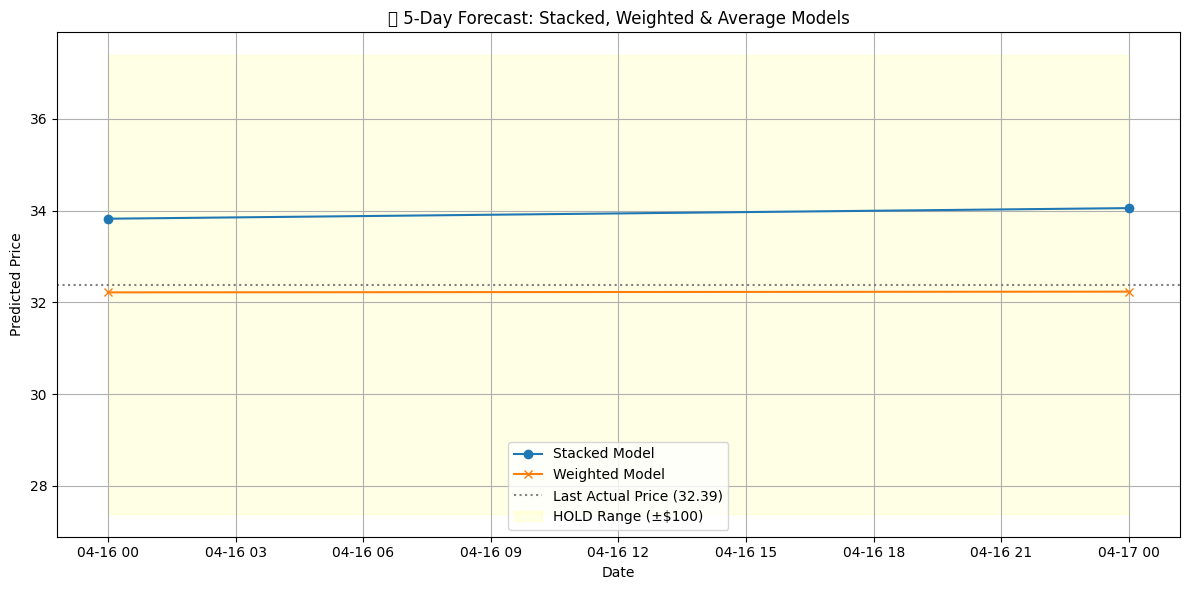

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n = 2  # Number of future predictions (default: 5 days)2
threshold = 5  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_weighted_future,
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_weighted_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY 📈")
    elif diff < -threshold:
        recommendations.append("SELL 📉")
    else:
        recommendations.append("HOLD ⚖️")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print(" Predicted Future Prices and Strategy:\n")
print(future_price)

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')
plt.plot(future_price.index, future_price['Future Price_weighted'], label='Weighted Model', marker='x')
plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$100)')
plt.title("📈 5-Day Forecast: Stacked, Weighted & Average Models")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




###  **Investment Summary – Forecast for 2025-04-16**

**Last Actual Observed Price**: $32.39

- **Predicted Price (Weighted Model)**: $32.22
   
- **Predicted Price (Stacked Model)**: $33.83
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Forecast for 2025-04-17**

- **Predicted Price (Weighted Model)**: $32.23
  
- **Predicted Price (Stacked Model)**: $34.06
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Conclusion**:
While the **stacked model shows a modest upward trend**, the **weighted model remains close to the current price**, indicating minimal movement. Both are **within the neutral range** (±$0.50 threshold). Therefore, no significant buy or sell signals are present at this point. The model advises **holding your current position** as market direction remains uncertain.

